# Распознавание объекта по форме
В данной работе я начну осваивать библиотеку `pytorch`. Работа выполнена в рамках лабораторной работы по дисциплине Цифровая обработка изображений.

По заданию необходимо сначала применить фильтр выделения границ на изображении в соответствии с вариантом (в моём случае это фильтр Робертса). После этого необходимо реализовать классификатор.

## 1. Предобработка
Для начала, следует сформировать выборки. Для этих целей укажем пути до файлов, после чего загрузим изображения, сразу переводя их в формат градации серого.

In [1]:
import numpy as np
import skimage as ski
import matplotlib.pyplot as plt

from pathlib import Path
from PIL import Image
from skimage.color import rgb2gray

In [2]:
path_train_dir_kohl = "./data/L1/train/kohlrabi"
path_train_dir_pear = "./data/L1/train/pear_monster"
path_test_dir_kohl = "./data/L1/test/kohlrabi"
path_test_dir_pear = "./data/L1/test/pear_monster"

train_dir_kohl = Path(path_train_dir_kohl)
train_dir_pear = Path(path_train_dir_pear)
test_dir_kohl = Path(path_test_dir_kohl)
test_dir_pear = Path(path_test_dir_pear)

In [3]:
gray_kohl_train = []
gray_pear_train = []
gray_kohl_test = []
gray_pear_test = []

for img_path in train_dir_kohl.iterdir():
    if img_path.is_dir(): continue
    with Image.open(img_path) as img:
        gray_kohl_train.append(rgb2gray(img))

for img_path in train_dir_pear.iterdir():
    if img_path.is_dir(): continue
    with Image.open(img_path) as img:
        gray_pear_train.append(rgb2gray(img))

for img_path in test_dir_kohl.iterdir():
    if img_path.is_dir(): continue
    with Image.open(img_path) as img:
        gray_kohl_test.append(rgb2gray(img))

for img_path in test_dir_pear.iterdir():
    if img_path.is_dir(): continue
    with Image.open(img_path) as img:
        gray_pear_test.append(rgb2gray(img))

In [4]:
kohl_train = [ski.filters.roberts(gray) for gray in gray_kohl_train]
pear_train = [ski.filters.roberts(gray) for gray in gray_pear_train]
kohl_test  = [ski.filters.roberts(gray) for gray in gray_kohl_test]
pear_test  = [ski.filters.roberts(gray) for gray in gray_pear_test]

## 1.1. Пример предобработки изображения
Чисто для наглядности покажем результаты преобразований на каждом этапе на примере одного изображения.

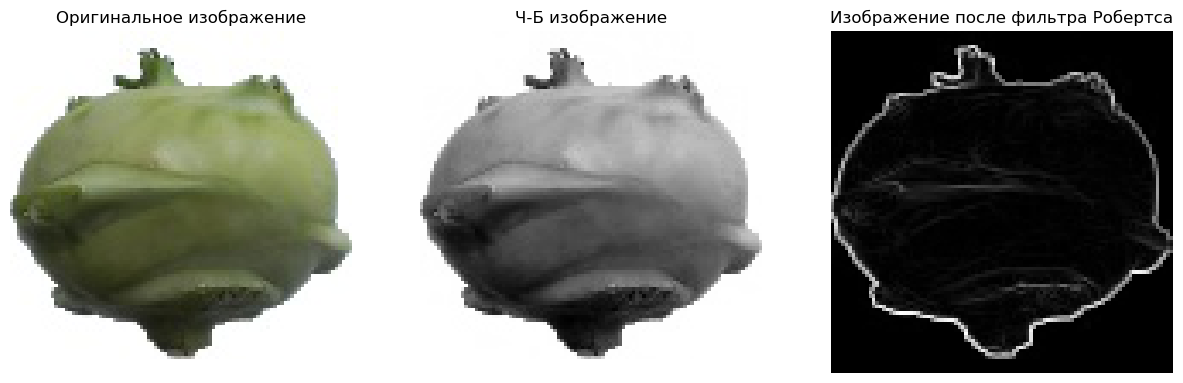

In [6]:
tmp_image = None
tmp_gray  = None
tmp_gray_img = None
tmp_filtered = None
tmp_filtered_img = None

with Image.open("./data/L1/train/kohlrabi/0_100.jpg") as img:
    tmp_image = img
    tmp_gray  = rgb2gray(img)
    tmp_gray_img = Image.fromarray((tmp_gray * 255).astype(np.uint8), mode='L')
    tmp_filtered = ski.filters.roberts(tmp_gray)
    tmp_filtered_img = Image.fromarray((tmp_filtered * 255).astype(np.uint8), mode='L')

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(tmp_image)
axes[0].set_title("Оригинальное изображение")
axes[0].axis(False)
axes[1].imshow(tmp_gray_img, cmap='Greys_r')
axes[1].set_title("Ч-Б изображение")
axes[1].axis(False)
axes[2].imshow(tmp_filtered_img, cmap='Greys_r')
axes[2].set_title("Изображение после фильтра Робертса")
axes[2].axis(False)
plt.show()

# 2. Машинное обучение
Для построения модели я буду использовать библиотеку `PyTorch`. Соответственно, потребуется дополнительная предобработка выборки.

In [7]:
import torch
import torch.optim as optim
from torchmetrics.classification import BinaryAccuracy, BinaryStatScores

from tqdm.auto import tqdm

from torch import nn
from torch.utils.data import DataLoader, TensorDataset

## 2.1. Обеспечение повторяемости результата
Далее, для обеспечения повторяемости эксперимента, зададим семена случайностей для библиотеки pytorch.

In [8]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

## 2.2. Определим устройство для вычислений
Определим устройство для вычислений в отдельную переменную.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [10]:
!nvidia-smi

Wed Apr 17 16:37:45 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 551.86                 Driver Version: 551.86         CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060      WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   49C    P8             10W /  170W |     556MiB /  12288MiB |      1%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 2.3. Подготовка данных для обучения и тестирования
Теперь можно приступать к предобработке.
* Во-первых, следует объединить отдельные списки данных по фруктам в единые списки для обучающей и тестовой выборок. Для этого просто проводим конкатенацию списков средствами самого python. Эти списки приведём к списку numpy.
* Во-вторых, данные надо привести от типа `np.ndarray` к `torch.Tensor` при помощи функции `tensor()` библиотеки `pytorch`.
* В-третьих, необходимо добавить ещё одно измерение к тензору, чтобы привести его форму от формата `(№ элемента, № пикселя по высоте, № пикселя по ширине)` к формату `(№ элемента, № цветового канала, № пикселя по высоте, № пикселя по ширине)`. Для этого используется метод `unsqueeze()` класса Tensor с аргументом 1, в качестве индекса нового измерения.
* В-четвёртых, необходимо привести данные к типу `torch.float`, чтобы функции библиотеки работали корректно.
* В-пятых, данные необходимо перевести на видеокарту при помощи метода `to()` класса `Tensor`, а в качестве аргумента передадим ранее определённую переменную `device`.
* В-шестых, создадим маркеры для этих данных и проведём для них почти все преобразования, описанные выше.
* В конце концов, теперь мы можем инициализировать с помощью этих данных необходимые датасеты.

In [11]:
# Определим лейблы, приведём данные к типу тензоров и поместим на целевое устройство
train = TensorDataset(
    torch.tensor(np.array(kohl_train + pear_train)).unsqueeze(dim=1).type(torch.float).to(device),
    torch.cat([torch.zeros(len(kohl_train)), torch.ones(len(pear_train))]).type(torch.float).to(device)
)
test = TensorDataset(
    torch.tensor(np.array(kohl_test + pear_test)).unsqueeze(dim=1).type(torch.float).to(device),
    torch.cat([torch.zeros(len(kohl_test)), torch.ones(len(pear_test))]).type(torch.float).to(device)
)

BATCH_SIZE = 32

trainloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
testloader  = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

In [12]:
print(f"Train total size: {len(trainloader.dataset)}")
print(f"Test  total size: {len(testloader.dataset)}")

print(f"Train batches count: {len(trainloader)}, train size: {len(trainloader) * BATCH_SIZE}")
print(f"Test  batches count: {len(testloader)}, test  size: {len(testloader) * BATCH_SIZE}")

Train total size: 961
Test  total size: 323
Train batches count: 30, train size: 960
Test  batches count: 10, test  size: 320


## 2.4. Создание модели
Теперь создадим модель. Она представляет собой свёрточную нейронную сеть со следующими слоями:
1. Свёртка (1 входной канал, 5 выходных каналов, размер ядра – 3, шаг – 1, расширение изображения по краям – 1);
2. ReLU;
3. Пуллинг (размер ядра – 2, шаг – 2);
4. Свёртка (те же параметры по порядку: 5, 20, 5, 1, 2);
5. ReLU;
6. Пуллинг (те же параметры);
7. Линеаризация (преобразует данные в одномерный список);
8. Полносвязный слой (число входов – 100 * 100 * 20 / 16 = 12500, число выходов – 1000);
9. ReLU;
10. Полносвязный слой (те же параметры по порядку: 1000, 1).

Выход данной нейронной сети – логит, что надо будет учитывать.


In [13]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        self.convolution_layers = nn.Sequential(
            nn.Conv2d(1, 5, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(5, 20, 5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        self.classification_layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(100 * 100 * 20 // 16, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.convolution_layers(x)
        x = self.classification_layers(x)
        return x

model = Model().to(device)
model

Model(
  (convolution_layers): Sequential(
    (0): Conv2d(1, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(5, 20, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classification_layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=12500, out_features=1000, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1000, out_features=1, bias=True)
  )
)

## 2.5. Обучение модели
Далее – самый длинный кусок кода – алгоритм обучения.
* Прежде всего, используем библиотеку time для засекания времени.
* Всего будет 1000 эпох обучения модели.
* Каждые 100 эпох будем выводить результаты модели.
* Будем сохранять метрики, чтобы вывести потом графики по эпохам.

Итак, основной цикл состоит из следующих шагов:
1. Перевод модели в режим обучения (влияет на поведение некоторых слоёв модели);
2. Цикл обучения;
    1. Из объекта класса `DataLoader` для выборки обучения извлекается партия данных и маркеров;
    2. Осуществляется прямой проход и сохраняются полученные логиты;
    3. К логитам применяется сигмоида, чтобы получить предсказанные значения;
    4. Вычисляется функция потерь;
    5. Обнуляется градиент в классе-оптимизаторе (т.к. он кумулятивный и может накапливать градиент);
    6. Осуществляется обратное распространение градиента;
    7. Применяется шаг оптимизатора, который меняет параметры модели.
3. Модель переводится в оценочный режим;
4. Активация режима оценки у библиотеки `pytorch` (отключает его некоторые модули, которые используются для вычисления градиента);
    1. Делаем предсказания;
    2. Вычисляем метрики;
    3. Сохраняем метрики в списки;
    4. Если прошло определённое количество эпох, то выводим результат текущих оценок функции потерь, точности, времени вычисления этих эпох.

Также в цикле используется библиотека `tqdm` для отслеживания прогресса.
 
По окончании цикла выводим общее время выполнения цикла.

In [14]:
accuraccy_fn   = BinaryAccuracy().to(device)
statsscores_fn = BinaryStatScores().to(device)

criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [15]:
import time

epochs = 1000
report_epochs = 100
losses     = np.zeros(epochs)
accuracies = np.zeros(epochs)
statscores = np.zeros((epochs, 5))

start_time = time.time()
prev_time  = start_time

for epoch in tqdm(range(epochs)):
    model.train()
    for inputs, labels in trainloader:
        logits  = model(inputs).squeeze()
        y_preds = torch.sigmoid(logits)
        loss = criterion(y_preds, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.inference_mode():
        test_inputs, test_outputs = testloader.dataset.tensors
        test_logits = model(test_inputs).squeeze()
        test_preds  = torch.sigmoid(test_logits)
        
        test_loss = criterion(test_preds, test_outputs)
        accuracy  = accuraccy_fn(test_preds, test_outputs)
        statscore = statsscores_fn(test_preds, test_outputs)
        
        losses[epoch]     = test_loss
        accuracies[epoch] = accuracy
        statscores[epoch] = statscore.cpu().numpy()
    
        if epoch % report_epochs == report_epochs - 1:
            current_time = time.time()
            print(f"[Эпоха: {epoch + 1:4d}] Ошибка: {test_loss:.5f} | Точность: {accuracy * 100:9.6f} % "
                  f"| Время выполнения {report_epochs} эпох: {current_time - prev_time:11.6f} секунд")
            prev_time = current_time

end_time = time.time()
print(f"Итоговое время расчёта: {end_time - start_time:11.6f} секунд.")

  0%|          | 0/1000 [00:00<?, ?it/s]

[Эпоха:  100] Ошибка: 0.09020 | Точность: 94.427246 % | Время выполнения 100 эпох:   12.582599 секунд
[Эпоха:  200] Ошибка: 0.07148 | Точность: 95.356033 % | Время выполнения 100 эпох:   11.358111 секунд
[Эпоха:  300] Ошибка: 0.06141 | Точность: 95.975235 % | Время выполнения 100 эпох:   11.390850 секунд
[Эпоха:  400] Ошибка: 0.05603 | Точность: 95.975235 % | Время выполнения 100 эпох:   11.278926 секунд
[Эпоха:  500] Ошибка: 0.05155 | Точность: 96.284828 % | Время выполнения 100 эпох:   11.300536 секунд
[Эпоха:  600] Ошибка: 0.04828 | Точность: 96.594429 % | Время выполнения 100 эпох:   11.312648 секунд
[Эпоха:  700] Ошибка: 0.04587 | Точность: 96.904030 % | Время выполнения 100 эпох:   11.298287 секунд
[Эпоха:  800] Ошибка: 0.04403 | Точность: 96.904030 % | Время выполнения 100 эпох:   11.301211 секунд
[Эпоха:  900] Ошибка: 0.04216 | Точность: 97.832817 % | Время выполнения 100 эпох:   11.325221 секунд
[Эпоха: 1000] Ошибка: 0.04065 | Точность: 97.832817 % | Время выполнения 100 эпох:

# 3. Результаты
Теперь отобразим результаты обучения по эпохам. Используем для этого библиотеку `matplotlib`.

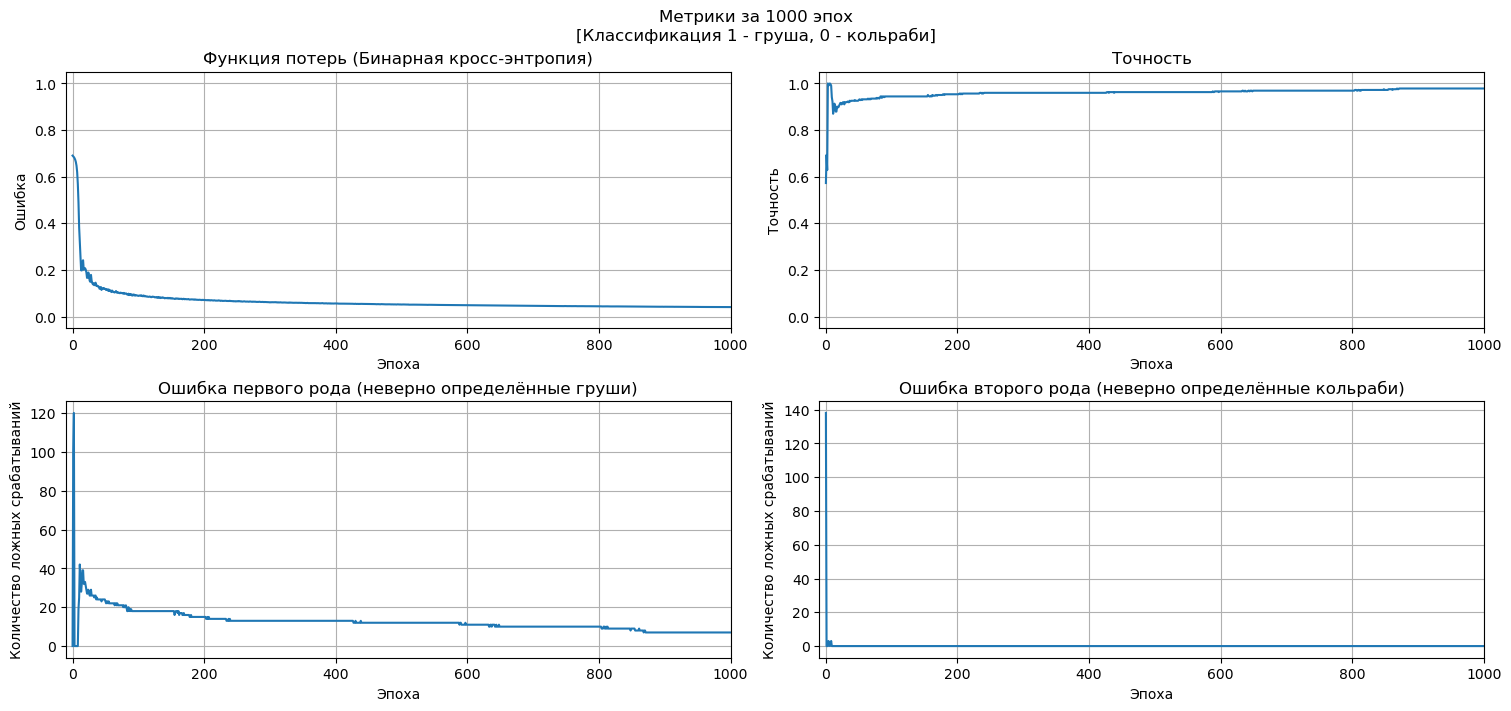

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(15, 7), layout='constrained')

plt.suptitle(f"Метрики за {epochs} эпох\n[Классификация 1 - груша, 0 - кольраби]")

for axes_row in axes:
    for ax in axes_row:
        ax.set_xlabel("Эпоха")
        ax.grid()
        ax.set_xlim((-10, 1000))

axes[0][0].plot(losses)
axes[0][0].set_title("Функция потерь (Бинарная кросс-энтропия)")
axes[0][0].set_ylabel("Ошибка")
axes[0][0].set_ylim((-0.05, 1.05))

axes[0][1].plot(accuracies)
axes[0][1].set_title("Точность")
axes[0][1].set_ylabel("Точность")
axes[0][1].set_ylim((-0.05, 1.05))

axes[1][0].plot(statscores[:, 1])
axes[1][0].set_title("Ошибка первого рода (неверно определённые груши)")
axes[1][0].set_ylabel("Количество ложных срабатываний")

axes[1][1].plot(statscores[:, 3])
axes[1][1].set_title("Ошибка второго рода (неверно определённые кольраби)")
axes[1][1].set_ylabel("Количество ложных срабатываний")

plt.show()